<a href="https://colab.research.google.com/github/MianzhiHu/UChicago_Propofol/blob/main/mixed_effect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("lme4", "optimx", "lmerTest", "emmeans", "effects", "pbkrtest"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mitools’, ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’, ‘carData’, ‘survey’, ‘insight’




In [ ]:
library(dplyr)
library(ggplot2)
library(tidyverse)
library(lme4)
library(optimx)
library(emmeans)
library(lmerTest)
library(effects)

In [ ]:
# Summarize data files with a mean r squared below 0.9
bad <- read.csv("/content/hurst_averages.csv") %>%
  separate(key, into = c("subject","nan1", "condition", "sedation_level", "nan2"), convert = TRUE, sep = "_") %>%
  select("subject", "condition", "sedation_level", "hurst_average", "r_squared") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  filter(r_squared < 0.9)

bad


Warning message:
“Expected 5 pieces. Additional pieces discarded in 116 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


subject,condition,sedation_level,hurst_average,r_squared
<chr>,<chr>,<fct>,<dbl>,<dbl>
02CB,movie,Recovery,0.3774158,0.8240143
04HD,movie,Mild,0.2053613,0.5082475
04HD,movie,Deep,0.3375646,0.7986721
08BC,movie,Recovery,0.4398759,0.8722272
10JR,movie,Mild,0.2932567,0.8410285
13CA,movie,Deep,0.5022003,0.8994623
17EK,movie,Awake,0.4390856,0.8582581
17NA,movie,Awake,0.4568628,0.8772828
17NA,movie,Deep,0.4292560,0.8813896


In [ ]:
# Preprocess hurst averages
x <- read.csv("/content/hurst_averages.csv") %>%
  separate(key, into = c("subject","nan1", "condition", "sedation_level", "nan2"), convert = TRUE, sep = "_") %>%
  select("subject", "condition", "sedation_level", "hurst_average", "r_squared") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  mutate(condition = fct_recode(condition,
                              "Rest" = "rest",
                              "Narrative Listening" = "movie")) %>%
  filter(r_squared > 0.9)
x$subject <- factor(x$subject)
x$sedation_level <- factor(x$sedation_level, levels=c("Awake","Mild", "Deep", "Recovery"))
x$condition <- factor(x$condition, levels=c("Rest","Narrative Listening"))


contrasts(x$sedation_level) = contr.poly(4)
options(contrasts=c("contr.sum","contr.poly"))

# Normalize the data
x$hurst <- scale(x$hurst_average)

hurst_mean <- mean(x$hurst_average)
hurst_sd <- sd(x$hurst_average)

x
hurst_mean
hurst_sd

# Count the occurrences of each category
category_counts <- table(x$condition)

# Display the category counts
print(category_counts)

movie_new <- x %>%
  filter(condition == "Narrative Listening")

movie_new

Warning message:
“Expected 5 pieces. Additional pieces discarded in 116 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


subject,condition,sedation_level,hurst_average,r_squared,hurst
<fct>,<fct>,<fct>,<dbl>,<dbl>,"<dbl[,1]>"
02CB,Narrative Listening,Awake,0.5676822,0.9341010,-0.37608605
02CB,Narrative Listening,Mild,0.6238171,0.9484309,0.24871305
02CB,Narrative Listening,Deep,0.6850942,0.9497898,0.93074695
02CB,Rest,Awake,0.7320398,0.9586631,1.45326619
02CB,Rest,Mild,0.6701008,0.9608697,0.76386614
02CB,Rest,Deep,0.6585643,0.9587932,0.63546097
02CB,Rest,Recovery,0.6103574,0.9602742,0.09890222
04HD,Narrative Listening,Awake,0.5734274,0.9380520,-0.31213980
04HD,Narrative Listening,Recovery,0.4670465,0.9402378,-1.49619330


[1] 0.6014715

[1] 0.08984469


               Rest Narrative Listening 
                 58                  44 


subject,condition,sedation_level,hurst_average,r_squared,hurst
<fct>,<fct>,<fct>,<dbl>,<dbl>,"<dbl[,1]>"
02CB,Narrative Listening,Awake,0.5676822,0.9341010,-0.37608605
02CB,Narrative Listening,Mild,0.6238171,0.9484309,0.24871305
02CB,Narrative Listening,Deep,0.6850942,0.9497898,0.93074695
04HD,Narrative Listening,Awake,0.5734274,0.9380520,-0.31213980
04HD,Narrative Listening,Recovery,0.4670465,0.9402378,-1.49619330
04SG,Narrative Listening,Awake,0.5829455,0.9447433,-0.20620046
04SG,Narrative Listening,Mild,0.6944752,0.9531031,1.03516067
04SG,Narrative Listening,Deep,0.7262578,0.9517813,1.38891087
04SG,Narrative Listening,Recovery,0.5017538,0.9303420,-1.10988986


In [ ]:
rest_new <- read.csv("/content/last_60_TR_average.csv") %>%
  separate(index, into = c("subject","nan1", "condition", "sedation_level", "nan2"), convert = TRUE, sep = "_") %>%
  select("subject", "condition", "sedation_level", "X0") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  mutate(condition = fct_recode(condition,
                              "Rest" = "rest")) %>%
  rename("hurst_average" = "X0") %>%
  full_join(movie_new)

rest_new$subject <- factor(rest_new$subject)
rest_new$sedation_level <- factor(rest_new$sedation_level, levels=c("Awake","Mild", "Deep", "Recovery"))
rest_new$condition <- factor(rest_new$condition, levels=c("Rest","Narrative Listening"))

contrasts(rest_new$sedation_level) = contr.poly(4)
options(contrasts=c("contr.sum","contr.poly"))

rest_new


Warning message:
“Expected 5 pieces. Additional pieces discarded in 31 rows [1, 2, 3, 4, 5, 6, 7,
8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Joining with `by = join_by(subject, condition, sedation_level, hurst_average)`


subject,condition,sedation_level,hurst_average,r_squared,hurst
<fct>,<fct>,<fct>,<dbl>,<dbl>,"<dbl[,1]>"
02CB,Rest,Awake,0.7278930,NA,NA
08VR,Rest,Awake,0.7013571,NA,NA
10JR,Rest,Awake,0.6866893,NA,NA
17EK,Rest,Awake,0.7461292,NA,NA
17NA,Rest,Awake,0.6724507,NA,NA
19SA,Rest,Awake,0.6758478,NA,NA
25JK,Rest,Awake,0.6615982,NA,NA
27HF,Rest,Awake,0.7263815,NA,NA
30AQ,Rest,Awake,0.6058827,NA,NA


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ sedation_level + (1 | subject) + (1 | condition)
   Data: rest_new

REML criterion at convergence: -125.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4345 -0.4837  0.0261  0.6456  1.6657 

Random effects:
 Groups    Name        Variance  Std.Dev.
 subject   (Intercept) 0.0008689 0.02948 
 condition (Intercept) 0.0025710 0.05070 
 Residual              0.0073544 0.08576 
Number of obs: 75, groups:  subject, 17; condition, 2

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)       0.6213993  0.0380262  1.0766178  16.341   0.0319 *
sedation_level.L -0.0108557  0.0192039 58.9232381  -0.565   0.5740  
sedation_level.Q -0.0176924  0.0205239 63.0380165  -0.862   0.3919  
sedation_level.C  0.0009333  0.0213849 59.4716141   0.044   0.9653  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation o

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,0.00821818,0.002739393,3,60.27085,0.3724853,0.7731331


$`emmeans of sedation_level`
 sedation_level emmean     SE   df lower.CL upper.CL
 Awake           0.620 0.0412 1.49    0.368    0.871
 Mild            0.633 0.0419 1.57    0.396    0.870
 Deep            0.627 0.0438 1.85    0.424    0.830
 Recovery        0.605 0.0412 1.49    0.354    0.857

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                estimate     SE   df t.ratio p.value
 Awake - Mild     -0.01367 0.0278 60.9  -0.492  0.9606
 Awake - Deep     -0.00757 0.0305 63.1  -0.248  0.9946
 Awake - Recovery  0.01415 0.0269 58.6   0.527  0.9523
 Mild - Deep       0.00611 0.0309 60.6   0.198  0.9972
 Mild - Recovery   0.02782 0.0278 60.7   1.001  0.7494
 Deep - Recovery   0.02171 0.0304 61.6   0.714  0.8912

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


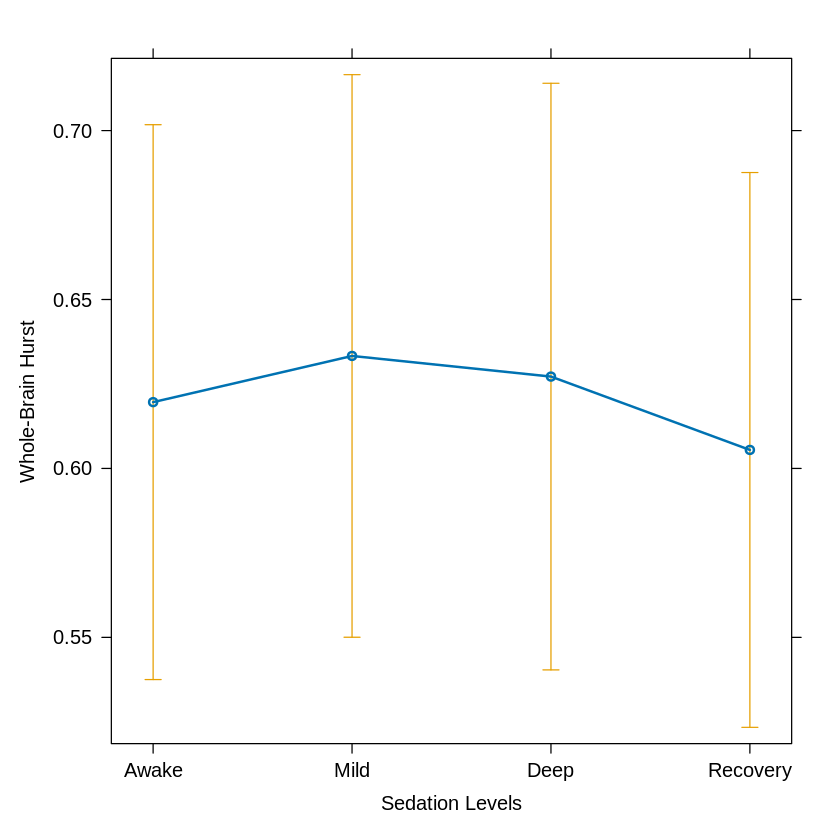

In [ ]:
# Main effect of sedation level (Non-standardized)
mixed_effect_total = lmer(hurst_average ~ sedation_level + (1 | subject) + (1 | condition), data=rest_new)
summary(mixed_effect_total)
anova(mixed_effect_total)
plot(allEffects(mixed_effect_total), xlab = "Sedation Levels", ylab = "Whole-Brain Hurst", main = '')
emmeans(mixed_effect_total, list(pairwise ~ sedation_level), adjust = "tukey")

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ condition + (1 | subject) + (1 | sedation_level)
   Data: rest_new

REML criterion at convergence: -138.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3679 -0.5269  0.0355  0.7008  1.8351 

Random effects:
 Groups         Name        Variance Std.Dev.
 subject        (Intercept) 0.000944 0.03072 
 sedation_level (Intercept) 0.000000 0.00000 
 Residual                   0.007103 0.08428 
Number of obs: 75, groups:  subject, 17; sedation_level, 4

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  0.62071    0.01257 15.18340  49.370  < 2e-16 ***
condition1   0.03693    0.01006 64.69458   3.669 0.000494 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
condition1 0.147 
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isS

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
condition,0.09561559,0.09561559,1,64.69458,13.46162,0.0004943959


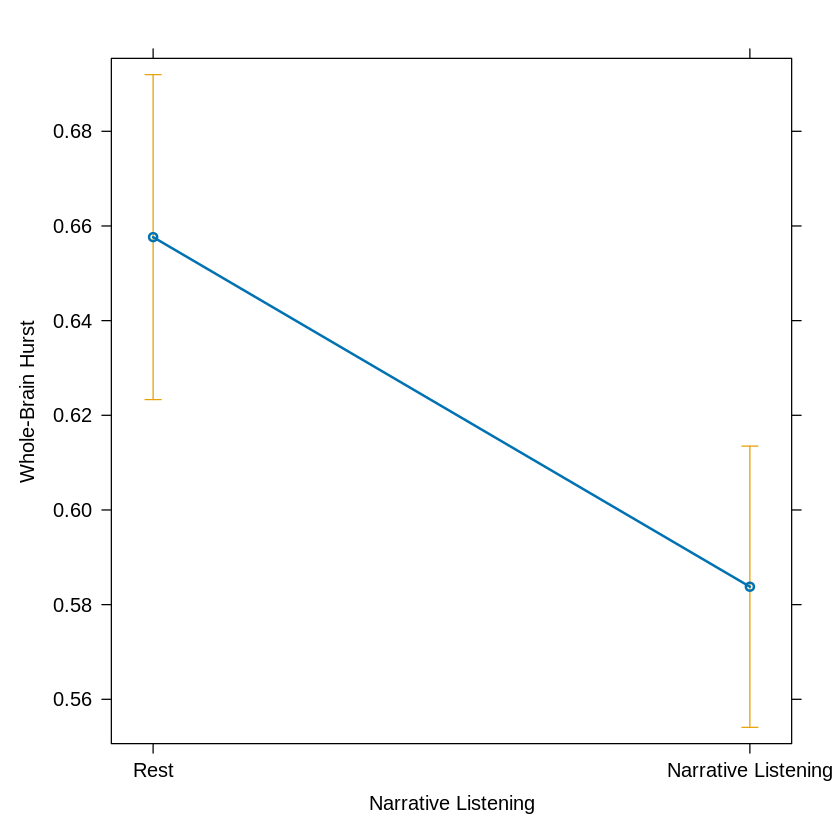

In [ ]:
# Main effect of movie/rest condition (Non-standardized)
mixed_effect_condition = lmer(hurst_average ~ condition + (1 | subject) + (1 | sedation_level), data=rest_new)
summary(mixed_effect_condition)
anova(mixed_effect_condition)
plot(allEffects(mixed_effect_condition), main = "", xlab = "Narrative Listening", ylab = "Whole-Brain Hurst")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ sedation_level * condition + (1 | subject)
   Data: rest_new

REML criterion at convergence: -118.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.89542 -0.57775  0.08765  0.60122  1.92964 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.001056 0.0325  
 Residual             0.005960 0.0772  
Number of obs: 75, groups:  subject, 17

Fixed effects:
                             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                  0.619195   0.012360 14.726112  50.098  < 2e-16 ***
sedation_level.L            -0.009236   0.017577 55.718233  -0.525 0.601348    
sedation_level.Q            -0.003969   0.018912 58.984002  -0.210 0.834499    
sedation_level.C            -0.009681   0.019755 56.347853  -0.490 0.625991    
condition1                   0.034866   0.009387 57.146759   3.714 0.000465 ***
seda

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,0.003593742,0.001197914,3,56.89342,0.2010089,0.8952679646
condition,0.082219336,0.082219336,1,57.14676,13.7963306,0.0004646135
sedation_level:condition,0.098937638,0.032979213,3,58.98005,5.5338822,0.0020446796


$`emmeans of sedation_level, condition`
 sedation_level condition           emmean     SE   df lower.CL upper.CL
 Awake          Rest                 0.700 0.0278 66.7    0.644    0.755
 Mild           Rest                 0.594 0.0314 67.0    0.531    0.656
 Deep           Rest                 0.653 0.0339 66.9    0.585    0.721
 Recovery       Rest                 0.670 0.0278 66.7    0.614    0.725
 Awake          Narrative Listening  0.552 0.0241 65.5    0.503    0.600
 Mild           Narrative Listening  0.640 0.0241 65.4    0.592    0.688
 Deep           Narrative Listening  0.598 0.0294 67.0    0.539    0.657
 Recovery       Narrative Listening  0.548 0.0241 65.5    0.500    0.596

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level, condition`
 1                                                        estimate     SE   df
 Awake Rest - Mild Rest                                    0.10582 0.0404 59.2
 Awake Rest - Deep 

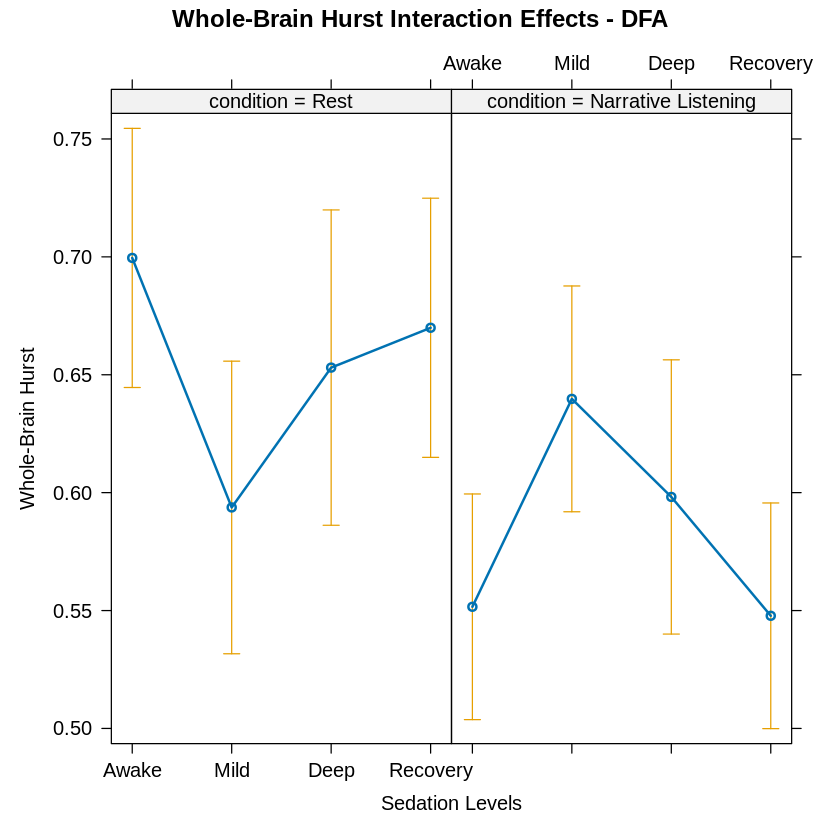

In [ ]:
# Interaction effects (Non-standardized)
mixed_effect = lmer(hurst_average ~ sedation_level*condition + (1 | subject), data=rest_new)
summary(mixed_effect)
anova(mixed_effect)
plot(allEffects(mixed_effect), main = "Whole-Brain Hurst Interaction Effects - DFA", xlab = "Sedation Levels", ylab = "Whole-Brain Hurst")
emmeans(mixed_effect, list(pairwise ~ sedation_level*condition), adjust = "tukey")

In [ ]:
# Incoporate framewise displacement
y <- read.csv("/ss_out_review_compiled_ANAT.csv") %>%
  rename("subject" = "sub",
          "condition" = "task",
          "sedation_level" = "run") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  full_join(x, by = c("subject", "sedation_level", "condition"))

ggplot(data = y) +
  geom_line(aes(x = motion, y = r_squared)) +
  geom_smooth(aes(x = motion, y = r_squared))

y

In [ ]:
# In case
z <- y %>%
  filter(r_squared > 0.9)

z

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ sedation_level + (1 | subject) + (1 | condition)
   Data: x

REML criterion at convergence: -180.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2535 -0.7188 -0.0695  0.7651  1.9479 

Random effects:
 Groups    Name        Variance  Std.Dev.
 subject   (Intercept) 0.0008173 0.02859 
 condition (Intercept) 0.0002477 0.01574 
 Residual              0.0072811 0.08533 
Number of obs: 102, groups:  subject, 17; condition, 2

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)   
(Intercept)       0.599484   0.015752  1.506566  38.058  0.00314 **
sedation_level.L -0.006516   0.016482 86.270962  -0.395  0.69358   
sedation_level.Q -0.016704   0.017377 88.733926  -0.961  0.33904   
sedation_level.C -0.002210   0.018024 85.544013  -0.123  0.90268   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Eff

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,0.008197411,0.00273247,3,86.71739,0.375281,0.7710405


$`emmeans of sedation_level`
 sedation_level emmean     SE   df lower.CL upper.CL
 Awake           0.596 0.0210 4.72    0.541    0.651
 Mild            0.608 0.0213 4.97    0.553    0.663
 Deep            0.608 0.0241 7.88    0.552    0.664
 Recovery        0.586 0.0210 4.69    0.531    0.641

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                 estimate     SE   df t.ratio p.value
 Awake - Mild     -1.18e-02 0.0234 87.6  -0.504  0.9579
 Awake - Deep     -1.19e-02 0.0259 88.9  -0.457  0.9680
 Awake - Recovery  9.73e-03 0.0231 85.1   0.422  0.9746
 Mild - Deep      -5.16e-05 0.0259 85.8  -0.002  1.0000
 Mild - Recovery   2.15e-02 0.0233 85.8   0.924  0.7919
 Deep - Recovery   2.16e-02 0.0257 85.5   0.841  0.8347

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


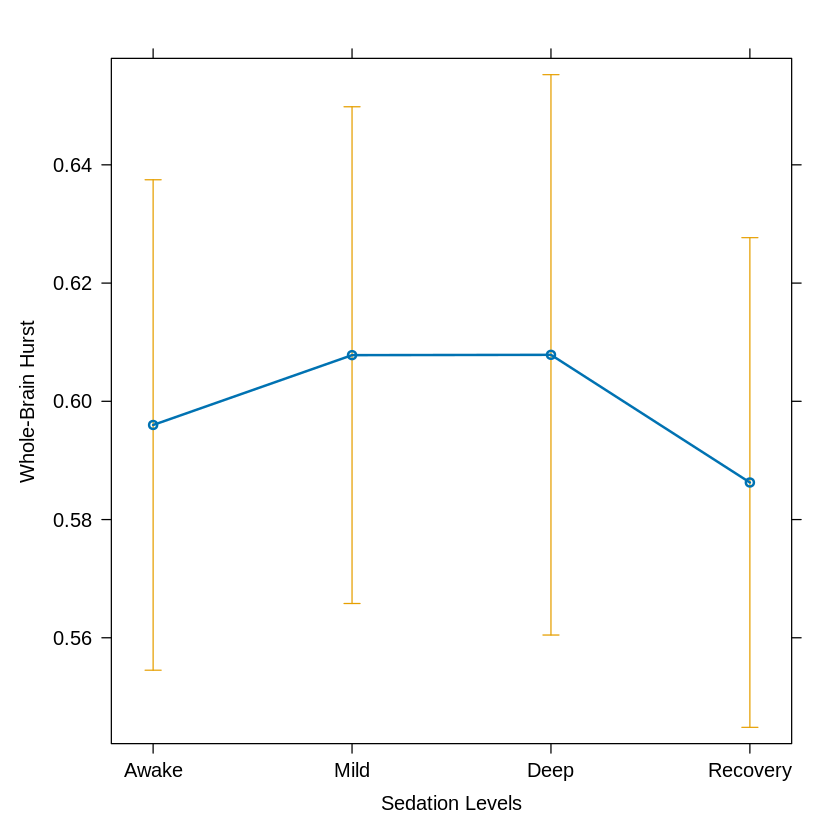

In [ ]:
# Main effect of sedation level (Non-standardized)
mixed_effect_total = lmer(hurst_average ~ sedation_level + (1 | subject) + (1 | condition), data=x)
summary(mixed_effect_total)
anova(mixed_effect_total)
plot(allEffects(mixed_effect_total), xlab = "Sedation Levels", ylab = "Whole-Brain Hurst", main = '')
emmeans(mixed_effect_total, list(pairwise ~ sedation_level), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level + (1 | subject) + (1 | condition)
   Data: x

REML criterion at convergence: 291.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2535 -0.7188 -0.0695  0.7651  1.9479 

Random effects:
 Groups    Name        Variance Std.Dev.
 subject   (Intercept) 0.10125  0.3182  
 condition (Intercept) 0.03068  0.1752  
 Residual              0.90202  0.9497  
Number of obs: 102, groups:  subject, 17; condition, 2

Fixed effects:
                 Estimate Std. Error       df t value Pr(>|t|)
(Intercept)      -0.02212    0.17532  1.50657  -0.126    0.914
sedation_level.L -0.07252    0.18345 86.27096  -0.395    0.694
sedation_level.Q -0.18592    0.19341 88.73393  -0.961    0.339
sedation_level.C -0.02460    0.20061 85.54401  -0.123    0.903

Correlation of Fixed Effects:
            (Intr) sdt_.L sdt_.Q
sedtn_lvl.L  0.030              
sedtn_lvl.Q -0.071 -0.054       


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,1.015528,0.3385093,3,86.71739,0.375281,0.7710405


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level`
 sedation_level  emmean    SE   df lower.CL upper.CL
 Awake          -0.0609 0.234 4.72   -0.673    0.551
 Mild            0.0706 0.237 4.97   -0.539    0.680
 Deep            0.0711 0.268 7.88   -0.548    0.691
 Recovery       -0.1692 0.233 4.69   -0.781    0.442

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                 estimate    SE   df t.ratio p.value
 Awake - Mild     -0.131480 0.261 87.6  -0.504  0.9579
 Awake - Deep     -0.132054 0.289 88.9  -0.457  0.9680
 Awake - Recovery  0.108301 0.257 85.1   0.422  0.9746
 Mild - Deep      -0.000575 0.288 85.8  -0.002  1.0000
 Mild - Recovery   0.239781 0.259 85.8   0.924  0.7919
 Deep - Recovery   0.240355 0.286 85.5   0.841  0.8347

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


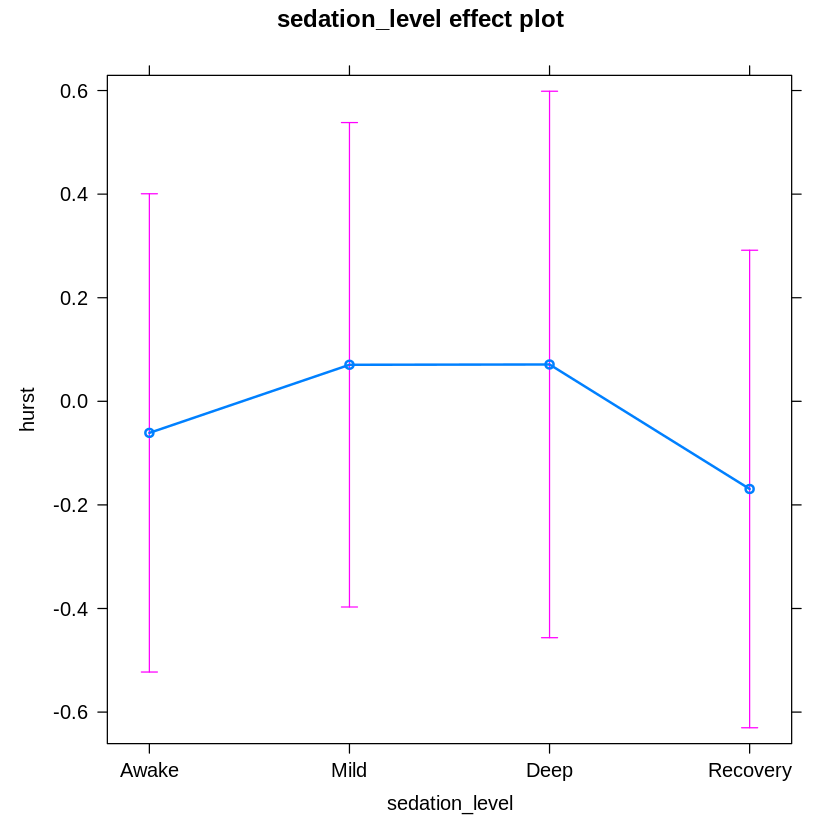

In [ ]:
# Main effect of sedation level
mixed_effect_total = lmer(hurst ~ sedation_level + (1 | subject) + (1 | condition), data=x)
summary(mixed_effect_total)
anova(mixed_effect_total)
plot(allEffects(mixed_effect_total))
emmeans(mixed_effect_total, list(pairwise ~ sedation_level), adjust = "tukey")

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ condition + (1 | subject) + (1 | sedation_level)
   Data: x

REML criterion at convergence: -193

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.21211 -0.69977 -0.03794  0.76136  2.03218 

Random effects:
 Groups         Name        Variance  Std.Dev.
 subject        (Intercept) 0.0009431 0.03071 
 sedation_level (Intercept) 0.0000000 0.00000 
 Residual                   0.0070599 0.08402 
Number of obs: 102, groups:  subject, 17; sedation_level, 4

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  0.597611   0.011302 16.852533  52.875   <2e-16 ***
condition1   0.014087   0.008467 88.321808   1.664   0.0997 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
condition1 -0.109
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: s

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
condition,0.01954185,0.01954185,1,88.32181,2.768003,0.09971049


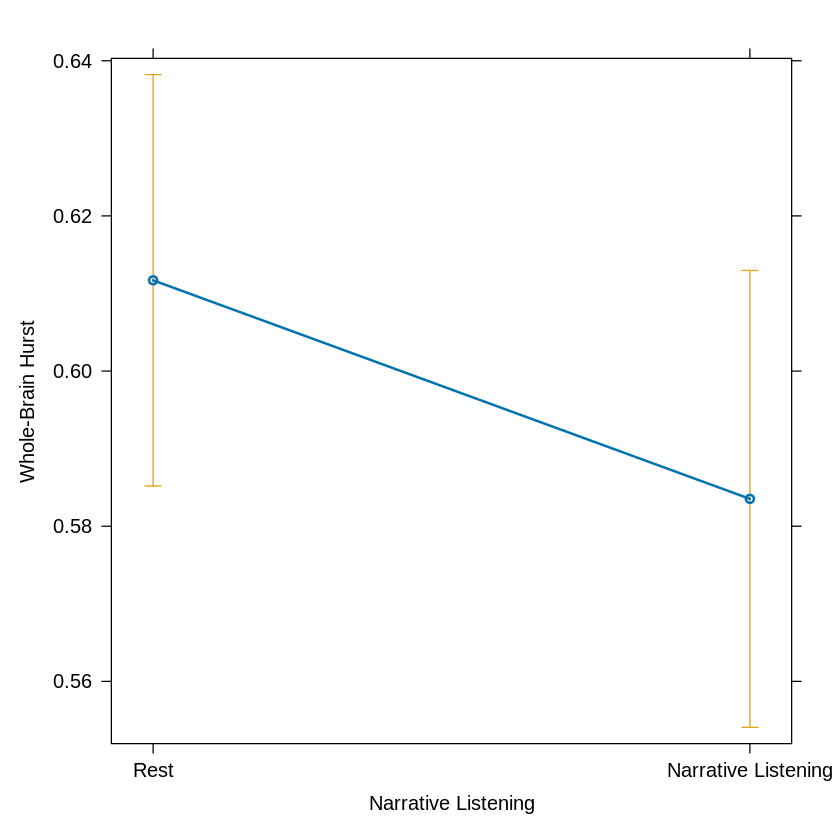

In [ ]:
# Main effect of movie/rest condition (Non-standardized)
mixed_effect_condition = lmer(hurst_average ~ condition + (1 | subject) + (1 | sedation_level), data=x)
summary(mixed_effect_condition)
anova(mixed_effect_condition)
plot(allEffects(mixed_effect_condition), main = "", xlab = "Narrative Listening", ylab = "Whole-Brain Hurst")

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ condition + (1 | subject) + (1 | sedation_level)
   Data: x

REML criterion at convergence: 288.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.21211 -0.69977 -0.03794  0.76136  2.03218 

Random effects:
 Groups         Name        Variance Std.Dev.
 subject        (Intercept) 0.1168   0.3418  
 sedation_level (Intercept) 0.0000   0.0000  
 Residual                   0.8746   0.9352  
Number of obs: 102, groups:  subject, 17; sedation_level, 4

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)  
(Intercept) -0.04297    0.12580 16.85253  -0.342   0.7369  
condition1   0.15680    0.09424 88.32181   1.664   0.0997 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
condition1 -0.109
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
condition,2.420922,2.420922,1,88.32181,2.768003,0.09971049


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


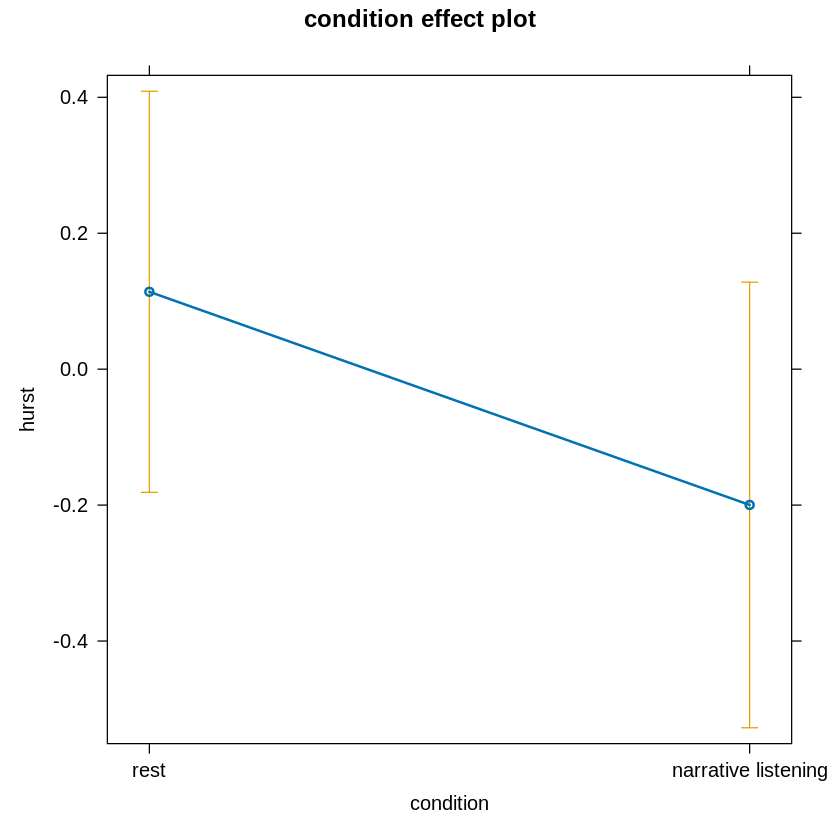

In [ ]:
# Main effect of movie/rest condition
mixed_effect_condition = lmer(hurst ~ condition + (1 | subject) + (1 | sedation_level), data=x)
summary(mixed_effect_condition)
anova(mixed_effect_condition)
plot(allEffects(mixed_effect_condition))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level + (1 | subject)
   Data: movie

REML criterion at convergence: 115

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.23946 -0.60283  0.09629  0.64905  1.46155 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.1259   0.3548  
 Residual             0.6814   0.8255  
Number of obs: 44, groups:  subject, 17

Fixed effects:
                 Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)       -0.1903     0.1559 15.6402  -1.221  0.24017   
sedation_level.L  -0.1311     0.2458 30.4081  -0.533  0.59781   
sedation_level.Q  -0.8071     0.2601 32.6240  -3.103  0.00394 **
sedation_level.C   0.2983     0.2700 31.4923   1.105  0.27765   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sdt_.L sdt_.Q
sedtn_lvl.L  0.056              
sedtn_lvl.Q -0.109 -0

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,8.523789,2.841263,3,31.47576,4.169457,0.01350965


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level`
 sedation_level  emmean    SE   df lower.CL upper.CL
 Awake          -0.5727 0.261 39.6  -1.1002  -0.0451
 Mild            0.4426 0.261 39.6  -0.0852   0.9704
 Deep           -0.0162 0.321 40.0  -0.6656   0.6333
 Recovery       -0.6151 0.261 39.6  -1.1428  -0.0874

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                estimate    SE   df t.ratio p.value
 Awake - Mild      -1.0153 0.353 32.3  -2.874  0.0341
 Awake - Deep      -0.5565 0.394 31.2  -1.412  0.5018
 Awake - Recovery   0.0425 0.350 30.5   0.121  0.9993
 Mild - Deep        0.4588 0.390 29.9   1.176  0.6461
 Mild - Recovery    1.0577 0.347 29.3   3.049  0.0236
 Deep - Recovery    0.5990 0.394 31.2   1.519  0.4387

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


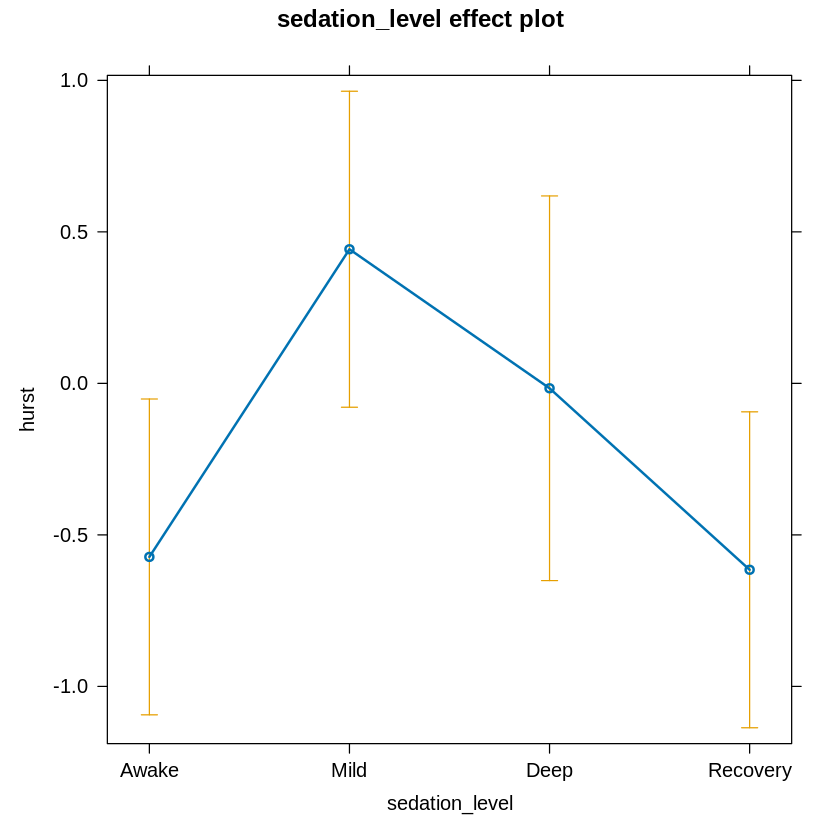

In [ ]:
# Main effect of sedation level within the movie condition
movie <- x %>%
  filter(condition == "narrative listening")

mixed_effect_movie = lmer(hurst ~ sedation_level + (1 | subject), data=movie)
summary(mixed_effect_movie)
anova(mixed_effect_movie)
plot(allEffects(mixed_effect_movie))
emmeans(mixed_effect_movie, list(pairwise ~ sedation_level), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level + (1 | subject)
   Data: rest

REML criterion at convergence: 166.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.01541 -0.77671  0.03399  0.74989  1.86700 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.00729  0.08538 
 Residual             1.01404  1.00700 
Number of obs: 58, groups:  subject, 17

Fixed effects:
                 Estimate Std. Error      df t value Pr(>|t|)
(Intercept)        0.1252     0.1355 13.6217   0.924    0.371
sedation_level.L  -0.0172     0.2551 39.2862  -0.067    0.947
sedation_level.Q   0.2440     0.2678 40.7882   0.911    0.368
sedation_level.C  -0.2848     0.2799 41.2872  -1.017    0.315

Correlation of Fixed Effects:
            (Intr) sdt_.L sdt_.Q
sedtn_lvl.L  0.040              
sedtn_lvl.Q -0.115 -0.041       
sedtn_lvl.C -0.109 -0.070  0.111

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,2.136414,0.712138,3,40.19069,0.702278,0.5562449


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level`
 sedation_level emmean    SE df lower.CL upper.CL
 Awake           0.322 0.253 54   -0.185    0.830
 Mild           -0.184 0.262 54   -0.709    0.341
 Deep            0.190 0.309 54   -0.429    0.810
 Recovery        0.172 0.253 54   -0.335    0.679

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                estimate    SE   df t.ratio p.value
 Awake - Mild       0.5064 0.363 40.8   1.394  0.5105
 Awake - Deep       0.1320 0.399 44.2   0.331  0.9873
 Awake - Recovery   0.1504 0.357 40.0   0.422  0.9745
 Mild - Deep       -0.3744 0.404 43.6  -0.927  0.7903
 Mild - Recovery   -0.3560 0.363 40.8  -0.980  0.7615
 Deep - Recovery    0.0185 0.398 42.7   0.046  1.0000

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


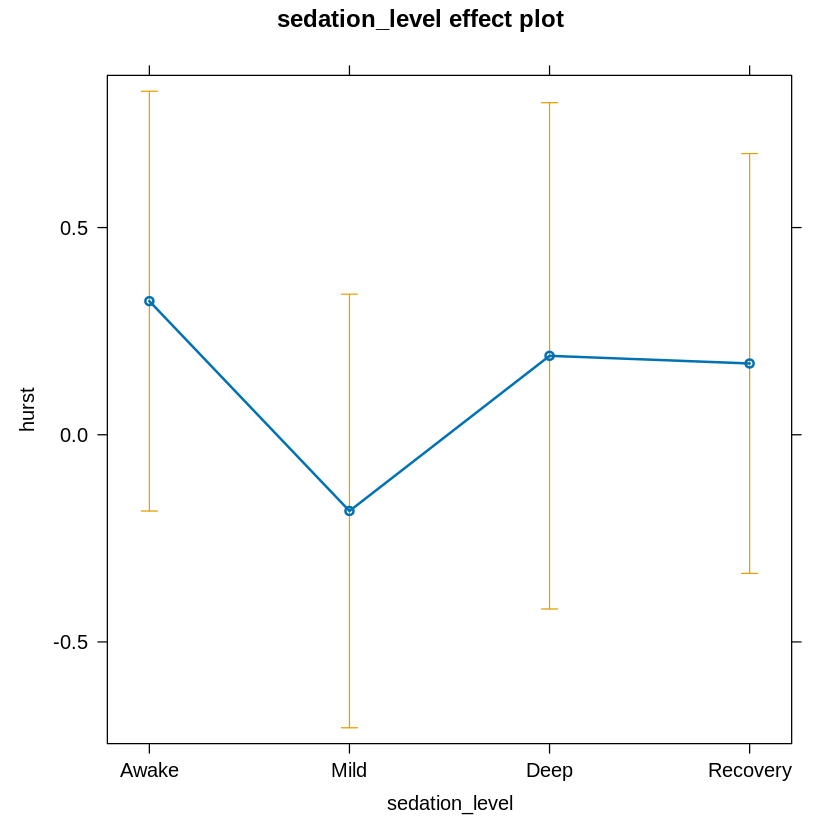

In [ ]:
# Main effect of sedation level within the rest condition
rest <- x %>%
  filter(condition == "rest")

mixed_effect_rest = lmer(hurst ~ sedation_level + (1 | subject), data=rest)
summary(mixed_effect_rest)
anova(mixed_effect_rest)
plot(allEffects(mixed_effect_rest))
emmeans(mixed_effect_rest, list(pairwise ~ sedation_level), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ sedation_level * condition + (1 | subject)
   Data: x

REML criterion at convergence: -167.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9290 -0.7005  0.0621  0.7656  2.0311 

Random effects:
 Groups   Name        Variance  Std.Dev.
 subject  (Intercept) 0.0008694 0.02949 
 Residual             0.0066271 0.08141 
Number of obs: 102, groups:  subject, 17

Fixed effects:
                             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                  0.598439   0.011016 17.137450  54.322  < 2e-16 ***
sedation_level.L            -0.006653   0.015917 83.601198  -0.418  0.67705    
sedation_level.Q            -0.022971   0.016795 85.975971  -1.368  0.17495    
sedation_level.C             0.001118   0.017395 82.828972   0.064  0.94890    
condition1                   0.013537   0.008328 82.707877   1.625  0.10787    
sedation_level.L:

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,0.01432195,0.004773984,3,84.04945,0.7203698,0.54258342
condition,0.01750992,0.017509920,1,82.70788,2.6421579,0.10786685
sedation_level:condition,0.07599774,0.025332580,3,82.30226,3.8225576,0.01285705


$`emmeans of sedation_level, condition`
 sedation_level condition           emmean     SE   df lower.CL upper.CL
 Awake          Rest                 0.631 0.0216 89.0    0.588    0.674
 Mild           Rest                 0.584 0.0223 89.8    0.539    0.628
 Deep           Rest                 0.618 0.0260 92.8    0.566    0.669
 Recovery       Rest                 0.616 0.0216 89.0    0.573    0.659
 Awake          Narrative Listening  0.552 0.0249 92.3    0.502    0.601
 Mild           Narrative Listening  0.641 0.0249 92.2    0.591    0.690
 Deep           Narrative Listening  0.598 0.0304 93.9    0.537    0.658
 Recovery       Narrative Listening  0.549 0.0249 92.3    0.500    0.599

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level, condition`
 1                                                        estimate     SE   df
 Awake Rest - Mild Rest                                    0.04696 0.0294 80.0
 Awake Rest - Deep 

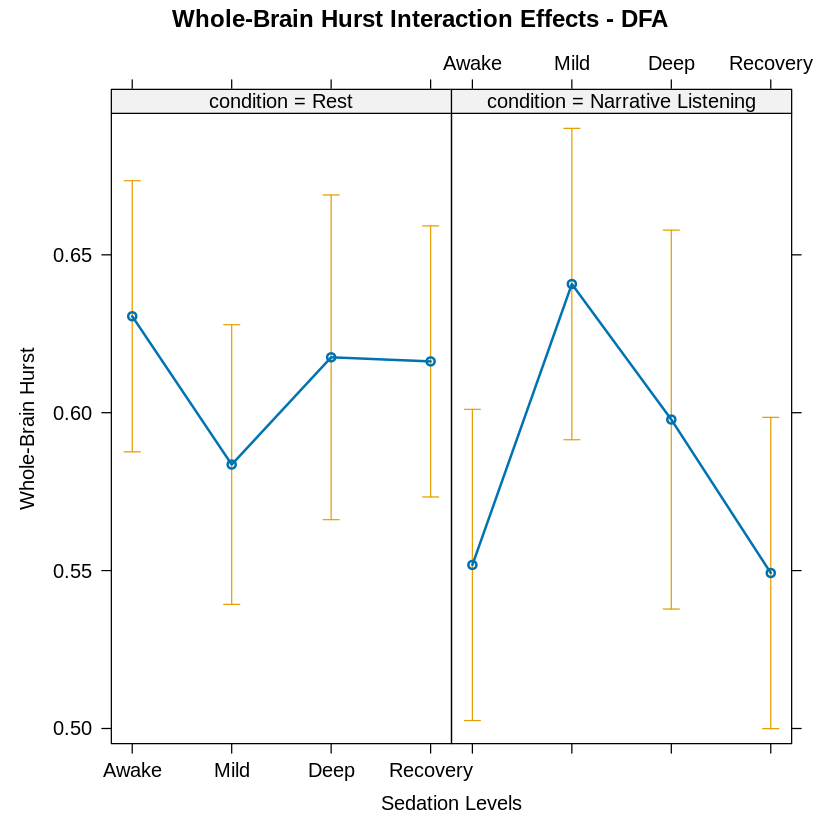

In [ ]:
# Interaction effects (Non-standardized)
mixed_effect = lmer(hurst_average ~ sedation_level*condition + (1 | subject), data=x)
summary(mixed_effect)
anova(mixed_effect)
plot(allEffects(mixed_effect), main = "Whole-Brain Hurst Interaction Effects - DFA", xlab = "Sedation Levels", ylab = "Whole-Brain Hurst")
emmeans(mixed_effect, list(pairwise ~ sedation_level*condition), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level * condition + (1 | subject)
   Data: x

REML criterion at convergence: 285.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9290 -0.7005  0.0621  0.7656  2.0311 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.1077   0.3282  
 Residual             0.8210   0.9061  
Number of obs: 102, groups:  subject, 17

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)   
(Intercept)                 -0.03375    0.12262 17.13745  -0.275  0.78639   
sedation_level.L            -0.07405    0.17716 83.60120  -0.418  0.67705   
sedation_level.Q            -0.25568    0.18693 85.97597  -1.368  0.17495   
sedation_level.C             0.01244    0.19361 82.82897   0.064  0.94890   
condition1                   0.15067    0.09269 82.70788   1.625  0.10787   
sedation_level.L:condition1  0.05183    0.17606

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,1.774260,0.5914201,3,84.04945,0.7203698,0.54258342
condition,2.169199,2.1691985,1,82.70788,2.6421579,0.10786685
sedation_level:condition,9.414902,3.1383008,3,82.30226,3.8225576,0.01285705


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level, condition`
 sedation_level condition  emmean    SE   df lower.CL upper.CL
 Awake          rest       0.3235 0.241 89.0   -0.155  0.80197
 Mild           rest      -0.1991 0.249 89.8   -0.693  0.29478
 Deep           rest       0.1789 0.290 92.8   -0.396  0.75394
 Recovery       rest       0.1644 0.241 89.0   -0.314  0.64284
 Awake          movie     -0.5529 0.277 92.3   -1.104 -0.00226
 Mild           movie      0.4371 0.277 92.2   -0.114  0.98817
 Deep           movie     -0.0405 0.339 93.9   -0.713  0.63198
 Recovery       movie     -0.5814 0.277 92.3   -1.132 -0.03049

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level, condition`
 1                              estimate    SE   df t.ratio p.value
 Awake rest - Mild rest           0.5226 0.327 80.0   1.596  0.7512
 Awake rest - Deep rest           0.1447 0.360 82.7   0.402  0.9999
 Awake rest - Recovery rest       0.1591 0.321 79.3   0.495  0.

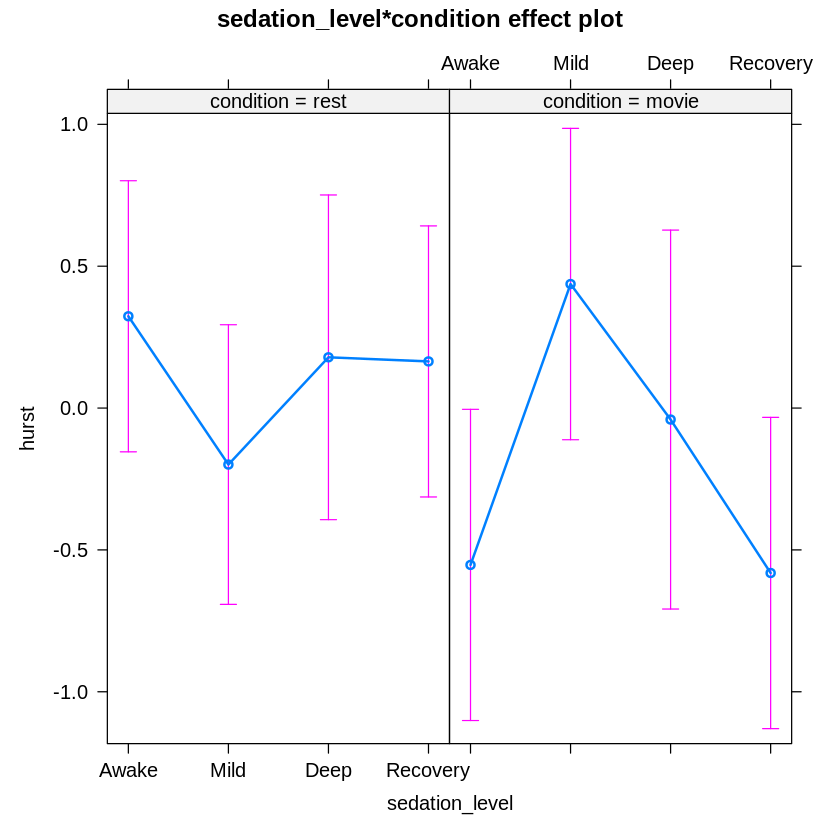

In [ ]:
# Interaction effects
mixed_effect = lmer(hurst ~ sedation_level*condition + (1 | subject), data=x)
summary(mixed_effect)
anova(mixed_effect)
plot(allEffects(mixed_effect))
emmeans(mixed_effect, list(pairwise ~ sedation_level*condition), adjust = "tukey")

In [ ]:
## The following code is to analyze wavelet hurst
# Preprocess wavelet hurst averages
wavelet <- read.csv("/content/wavelet_df_mean.csv") %>%
  separate(X, into = c("subject","nan1", "condition", "sedation_level", "nan2"), convert = TRUE, sep = "_")  %>%
  select("subject", "condition", "sedation_level", "hurst_average") %>%
  mutate(sedation_level = as.character(sedation_level)) %>%
  mutate(sedation_level = fct_recode(sedation_level,
                                "Awake" = "1",
                                "Mild" = "2",
                                "Deep" = "3",
                                "Recovery" = "4")) %>%
  mutate(condition = fct_recode(condition,
                            "Rest" = "rest",
                            "Narrative Listening" = "movie"))

wavelet$subject <- factor(wavelet$subject)
wavelet$sedation_level <- factor(wavelet$sedation_level, levels=c("Awake","Mild", "Deep", "Recovery"))
wavelet$condition <- factor(wavelet$condition, levels=c("Rest","Narrative Listening"))


contrasts(wavelet$sedation_level) = contr.poly(4)
options(contrasts=c("contr.sum","contr.poly"))

# Normalize the data
wavelet$hurst <- scale(wavelet$hurst_average)

wavelet

Warning message:
“Expected 5 pieces. Additional pieces discarded in 116 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


subject,condition,sedation_level,hurst_average,hurst
<fct>,<fct>,<fct>,<dbl>,"<dbl[,1]>"
02CB,Narrative Listening,Awake,0.5321307,-1.08580007
02CB,Narrative Listening,Mild,0.8700108,1.55367710
02CB,Narrative Listening,Deep,0.6198189,-0.40079029
02CB,Narrative Listening,Recovery,NA,NA
02CB,Rest,Awake,0.7574029,0.67399847
02CB,Rest,Mild,0.7047818,0.26292917
02CB,Rest,Deep,0.6933563,0.17367457
02CB,Rest,Recovery,0.6021268,-0.53899877
04HD,Narrative Listening,Awake,0.5916899,-0.62053033


boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ sedation_level + (1 | subject) + (1 | condition)
   Data: wavelet

REML criterion at convergence: -102.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.47677 -0.62966  0.00483  0.64549  2.52090 

Random effects:
 Groups    Name        Variance  Std.Dev.
 subject   (Intercept) 0.0000000 0.00000 
 condition (Intercept) 0.0002387 0.01545 
 Residual              0.0163418 0.12784 
Number of obs: 96, groups:  subject, 17; condition, 2

Fixed effects:
                 Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)       0.67200    0.01725  0.95082  38.949   0.0194 *
sedation_level.L -0.03140    0.02535 91.13284  -1.238   0.2188  
sedation_level.Q -0.01880    0.02644 91.17783  -0.711   0.4789  
sedation_level.C  0.01615    0.02746 91.02140   0.588   0.5579  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Eff

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,0.04092987,0.01364329,3,91.11891,0.8348707,0.4781399


$`emmeans of sedation_level`
 sedation_level emmean     SE    df lower.CL upper.CL
 Awake           0.680 0.0280  5.86    0.611    0.749
 Mild            0.699 0.0277  5.94    0.631    0.767
 Deep            0.664 0.0329 10.62    0.591    0.736
 Recovery        0.645 0.0283  5.75    0.575    0.715

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                estimate     SE   df t.ratio p.value
 Awake - Mild      -0.0192 0.0357 82.5  -0.538  0.9494
 Awake - Deep       0.0165 0.0397 87.3   0.416  0.9756
 Awake - Recovery   0.0349 0.0357 80.8   0.979  0.7619
 Mild - Deep        0.0357 0.0395 83.8   0.903  0.8032
 Mild - Recovery    0.0541 0.0358 82.7   1.511  0.4358
 Deep - Recovery    0.0184 0.0397 86.2   0.464  0.9668

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


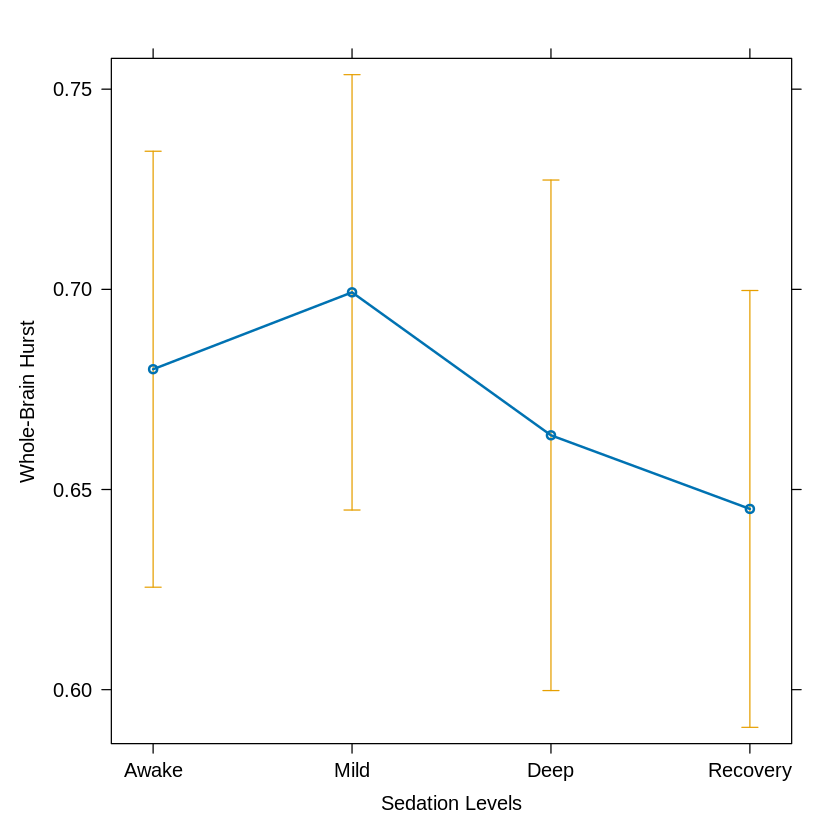

In [ ]:
# Main effect of sedation level (Non-standardized)
wavelet_total = lmer(hurst_average ~ sedation_level + (1 | subject) + (1 | condition), data=wavelet)
summary(wavelet_total)
anova(wavelet_total)
plot(allEffects(wavelet_total), main = "", xlab = "Sedation Levels", ylab = "Whole-Brain Hurst")
emmeans(wavelet_total, list(pairwise ~ sedation_level), adjust = "tukey")

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level + (1 | subject) + (1 | condition)
   Data: wavelet

REML criterion at convergence: 275.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.47677 -0.62966  0.00483  0.64549  2.52090 

Random effects:
 Groups    Name        Variance Std.Dev.
 subject   (Intercept) 0.00000  0.0000  
 condition (Intercept) 0.01456  0.1207  
 Residual              0.99726  0.9986  
Number of obs: 96, groups:  subject, 17; condition, 2

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)
(Intercept)       0.006836   0.134779  0.950825   0.051    0.968
sedation_level.L -0.245265   0.198061 91.132837  -1.238    0.219
sedation_level.Q -0.146843   0.206512 91.177827  -0.711    0.479
sedation_level.C  0.126183   0.214549 91.021396   0.588    0.558

Correlation of Fixed Effects:
            (Intr) sdt_.L sdt_.Q
sedtn_lvl.L  0.038              
sedtn_lv

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,2.497761,0.8325869,3,91.11891,0.8348707,0.4781399


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level`
 sedation_level  emmean    SE    df lower.CL upper.CL
 Awake           0.0697 0.218  5.86   -0.468    0.607
 Mild            0.2197 0.217  5.94   -0.311    0.751
 Deep           -0.0592 0.257 10.62   -0.627    0.508
 Recovery       -0.2029 0.221  5.75   -0.750    0.344

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                estimate    SE   df t.ratio p.value
 Awake - Mild       -0.150 0.279 82.5  -0.538  0.9494
 Awake - Deep        0.129 0.310 87.3   0.416  0.9756
 Awake - Recovery    0.273 0.279 80.8   0.979  0.7619
 Mild - Deep         0.279 0.309 83.8   0.903  0.8032
 Mild - Recovery     0.423 0.280 82.7   1.511  0.4358
 Deep - Recovery     0.144 0.310 86.2   0.464  0.9668

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


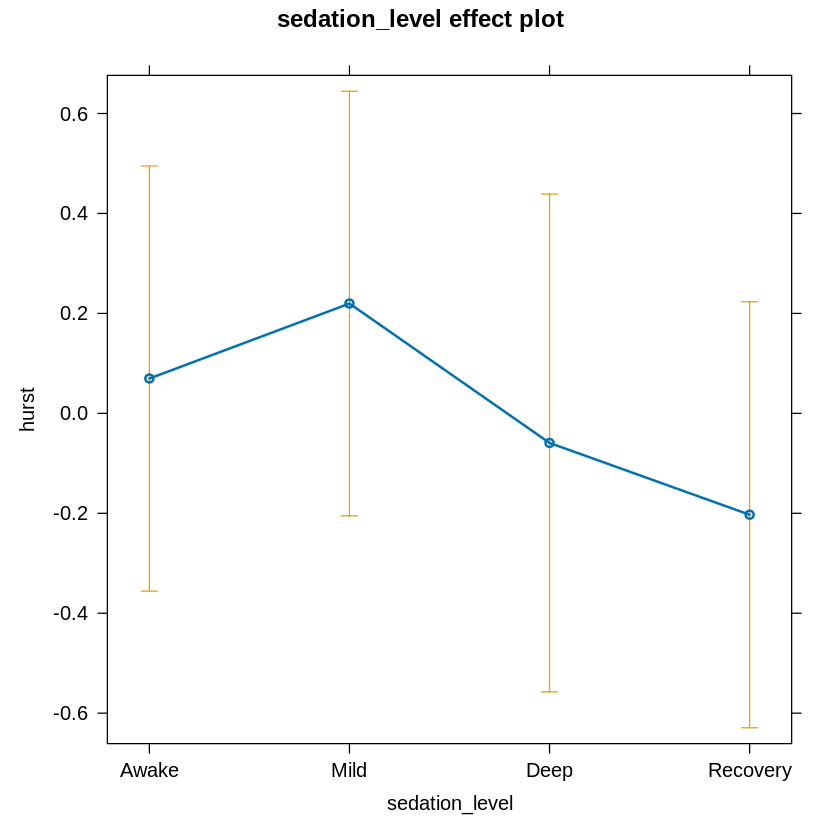

In [ ]:
# Main effect of sedation level
wavelet_total = lmer(hurst ~ sedation_level + (1 | subject) + (1 | condition), data=wavelet)
summary(wavelet_total)
anova(wavelet_total)
plot(allEffects(wavelet_total))
emmeans(wavelet_total, list(pairwise ~ sedation_level), adjust = "tukey")

boundary (singular) fit: see help('isSingular')



,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
condition,0.03095486,0.03095486,1,94,1.907069,0.1705637


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ condition + (1 | subject) + (1 | sedation_level)
   Data: wavelet

REML criterion at convergence: -111.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.25147 -0.67122  0.07807  0.65006  2.34606 

Random effects:
 Groups         Name        Variance Std.Dev.
 subject        (Intercept) 0.00000  0.0000  
 sedation_level (Intercept) 0.00000  0.0000  
 Residual                   0.01623  0.1274  
Number of obs: 96, groups:  subject, 17; sedation_level, 4

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  0.67535    0.01336 94.00000  50.556   <2e-16 ***
condition1  -0.01845    0.01336 94.00000  -1.381    0.171    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
condition1 -0.229
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see 

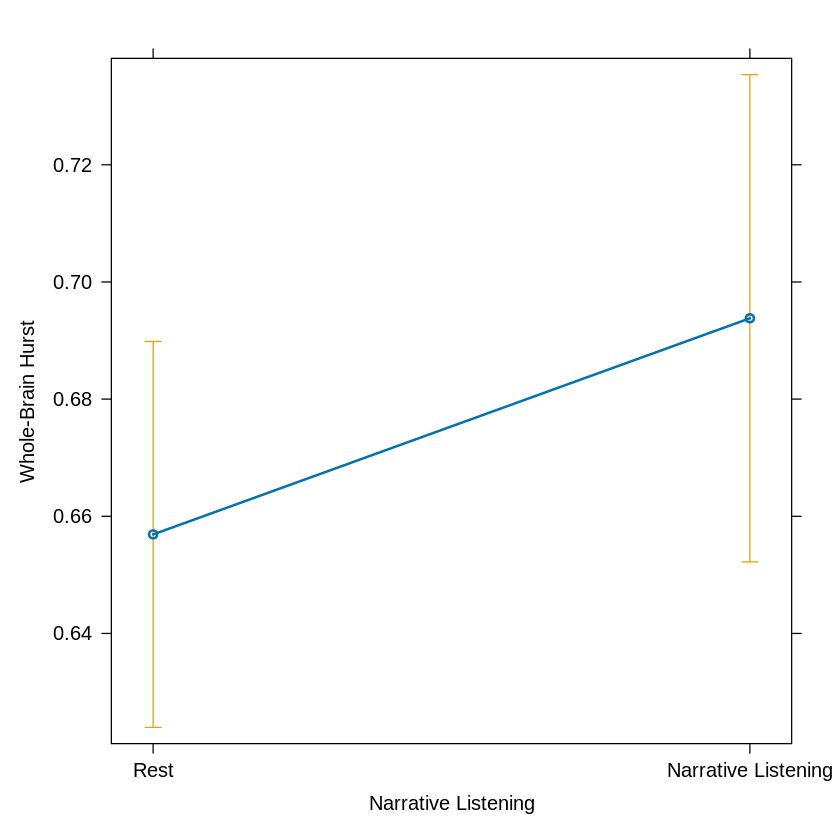

In [ ]:
# Main effect of movie/rest condition in wavelet (Non-standardized)
wavelet_condition = lmer(hurst_average ~ condition + (1 | subject) + (1 | sedation_level), data=wavelet)
anova(wavelet_condition)
summary(wavelet_condition)
plot(allEffects(wavelet_condition), main = "", xlab = "Narrative Listening", ylab = "Whole-Brain Hurst")

boundary (singular) fit: see help('isSingular')



,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
condition,1.889032,1.889032,1,94,1.907069,0.1705637


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ condition + (1 | subject) + (1 | sedation_level)
   Data: wavelet

REML criterion at convergence: 274.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.25147 -0.67122  0.07807  0.65006  2.34606 

Random effects:
 Groups         Name        Variance Std.Dev.
 subject        (Intercept) 0.0000   0.0000  
 sedation_level (Intercept) 0.0000   0.0000  
 Residual                   0.9905   0.9953  
Number of obs: 96, groups:  subject, 17; sedation_level, 4

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)
(Intercept)  0.03303    0.10436 94.00000   0.316    0.752
condition1  -0.14411    0.10436 94.00000  -1.381    0.171

Correlation of Fixed Effects:
           (Intr)
condition1 -0.229
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


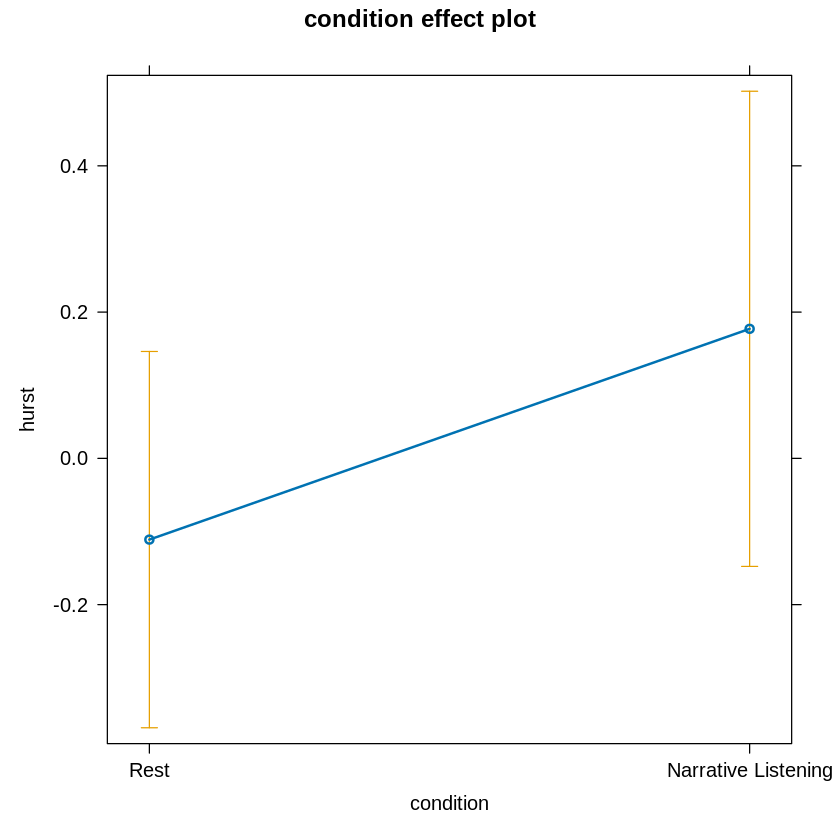

In [ ]:
# Main effect of movie/rest condition in wavelet
wavelet_condition = lmer(hurst ~ condition + (1 | subject) + (1 | sedation_level), data=wavelet)
anova(wavelet_condition)
summary(wavelet_condition)
plot(allEffects(wavelet_condition))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level + (1 | subject)
   Data: movie_wavelet

REML criterion at convergence: 105.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.50040 -0.53683 -0.09076  0.44551  2.01752 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.2303   0.4799  
 Residual             0.8622   0.9286  
Number of obs: 37, groups:  subject, 16

Fixed effects:
                 Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)       0.10746    0.20073 15.32756   0.535   0.6001  
sedation_level.L -0.01311    0.31486 26.46874  -0.042   0.9671  
sedation_level.Q -0.74230    0.32424 27.41815  -2.289   0.0300 *
sedation_level.C  0.58588    0.32732 25.87892   1.790   0.0852 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sdt_.L sdt_.Q
sedtn_lvl.L  0.062              
sedtn_lvl.Q

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,8.899203,2.966401,3,26.39354,3.440378,0.03107973


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level`
 sedation_level  emmean    SE   df lower.CL upper.CL
 Awake          -0.3859 0.333 32.8   -1.063    0.291
 Mild            0.8746 0.317 32.5    0.229    1.520
 Deep            0.0827 0.399 33.0   -0.728    0.894
 Recovery       -0.1415 0.351 32.9   -0.855    0.572

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                estimate    SE   df t.ratio p.value
 Awake - Mild       -1.260 0.427 24.1  -2.955  0.0326
 Awake - Deep       -0.469 0.486 24.3  -0.965  0.7702
 Awake - Recovery   -0.244 0.457 26.3  -0.535  0.9498
 Mild - Deep         0.792 0.471 23.4   1.680  0.3561
 Mild - Recovery     1.016 0.443 25.5   2.294  0.1261
 Deep - Recovery     0.224 0.512 27.6   0.438  0.9713

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


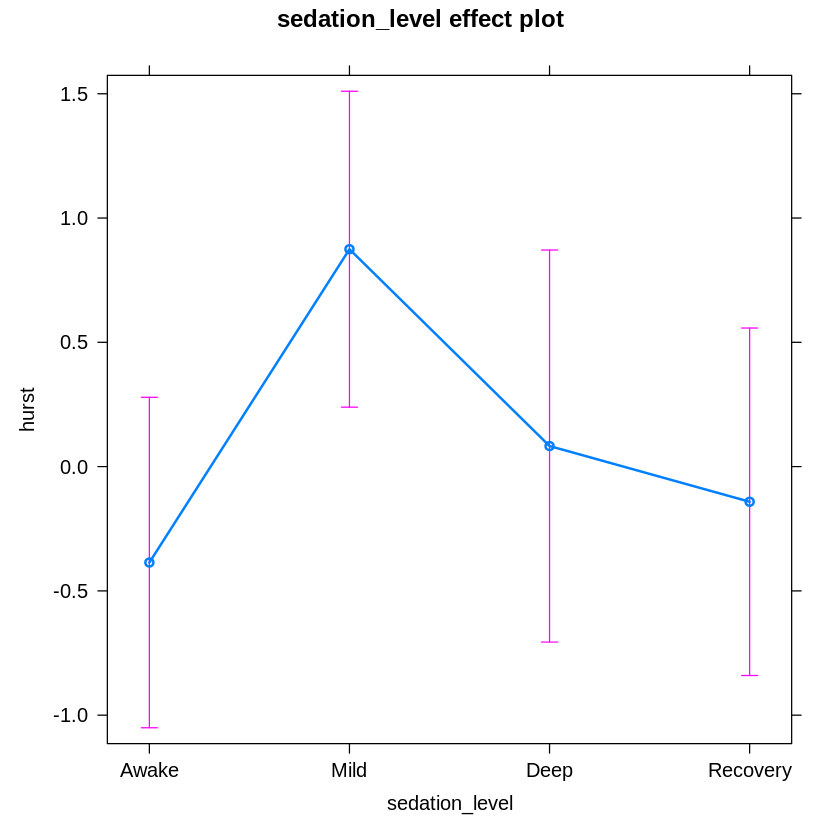

In [ ]:
# Main effect of sedation level within the movie condition in wavelet
movie_wavelet <- wavelet %>%
  filter(condition == "movie")

wavelet_movie = lmer(hurst ~ sedation_level + (1 | subject), data=movie_wavelet)
summary(wavelet_movie)
anova(wavelet_movie)
plot(allEffects(wavelet_movie))
emmeans(wavelet_movie, list(pairwise ~ sedation_level), adjust = "tukey")

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level + (1 | subject)
   Data: rest_wavelet

REML criterion at convergence: 156.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2773 -0.4904  0.1067  0.5965  2.0351 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.0000   0.0000  
 Residual             0.8073   0.8985  
Number of obs: 59, groups:  subject, 17

Fixed effects:
                 Estimate Std. Error      df t value Pr(>|t|)
(Intercept)       -0.1128     0.1186 55.0000  -0.951    0.346
sedation_level.L  -0.3601     0.2246 55.0000  -1.603    0.115
sedation_level.Q   0.2034     0.2373 55.0000   0.857    0.395
sedation_level.C  -0.2371     0.2493 55.0000  -0.951    0.346

Correlation of Fixed Effects:
            (Intr) sdt_.L sdt_.Q
sedtn_lvl.L  0.022              
sedtn_lvl.Q -0.130 -0.060       
sedtn_lvl.C -0.117 -0.078  0.105
optimizer (nloptwrap) convergence code

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,3.637353,1.212451,3,55,1.501782,0.2242653


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level`
 sedation_level emmean    SE df lower.CL upper.CL
 Awake           0.283 0.225 55   -0.168    0.735
 Mild           -0.293 0.233 55   -0.760    0.174
 Deep           -0.136 0.275 55   -0.687    0.415
 Recovery       -0.306 0.218 55   -0.742    0.131

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level`
 1                estimate    SE   df t.ratio p.value
 Awake - Mild       0.5764 0.324 41.7   1.779  0.2978
 Awake - Deep       0.4194 0.355 45.2   1.180  0.6425
 Awake - Recovery   0.5891 0.313 40.2   1.880  0.2527
 Mild - Deep       -0.1570 0.360 44.6  -0.436  0.9719
 Mild - Recovery    0.0127 0.319 40.9   0.040  1.0000
 Deep - Recovery    0.1697 0.351 44.3   0.484  0.9623

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


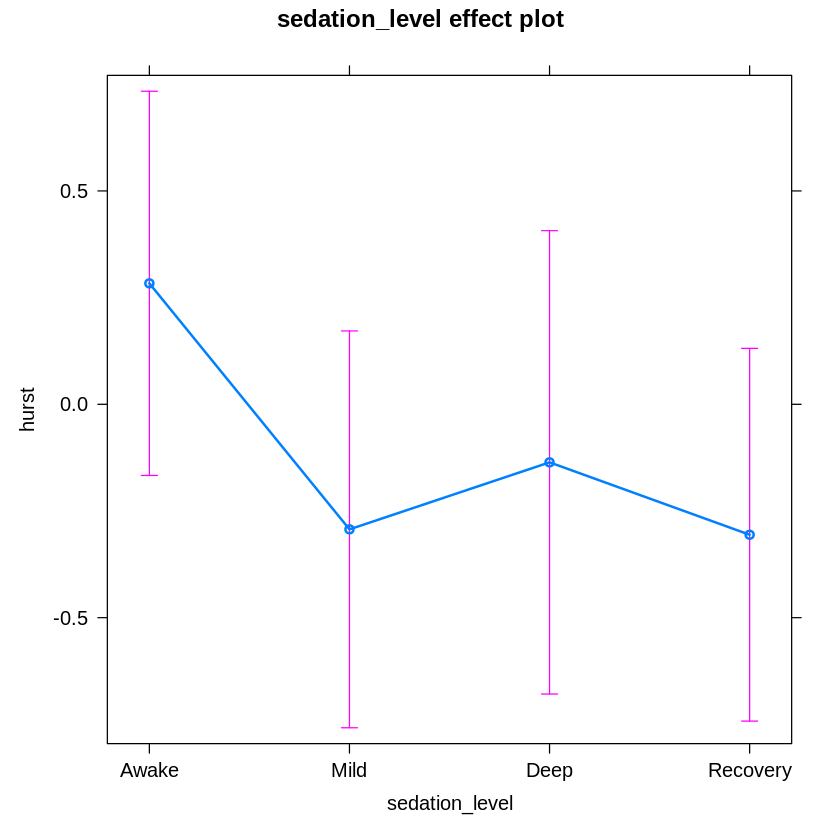

In [ ]:
# Main effect of sedation level within the rest condition in wavelet
rest_wavelet <- wavelet %>%
  filter(condition == "rest")

wavelet_rest = lmer(hurst ~ sedation_level + (1 | subject), data=rest_wavelet)
summary(wavelet_rest)
anova(wavelet_rest)
plot(allEffects(wavelet_rest))
emmeans(wavelet_rest, list(pairwise ~ sedation_level), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst_average ~ sedation_level * condition + (1 | subject)
   Data: wavelet

REML criterion at convergence: -91.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.16027 -0.51071  0.04279  0.59173  2.56465 

Random effects:
 Groups   Name        Variance  Std.Dev.
 subject  (Intercept) 0.0001127 0.01062 
 Residual             0.0149282 0.12218 
Number of obs: 96, groups:  subject, 17

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                  0.67289    0.01327 16.67100  50.714   <2e-16 ***
sedation_level.L            -0.02472    0.02516 80.63312  -0.983   0.3286    
sedation_level.Q            -0.02827    0.02604 84.91851  -1.086   0.2808    
sedation_level.C             0.02578    0.02685 80.70893   0.960   0.3399    
condition1                  -0.01622    0.01301 80.92746  -1.247   0.2161    
sedation_level.

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,0.05061603,0.01687201,3,81.94549,1.130208,0.34177702
condition,0.02320343,0.02320343,1,80.92746,1.554333,0.21609340
sedation_level:condition,0.16386770,0.05462257,3,78.53337,3.659012,0.01589395


$`emmeans of sedation_level, condition`
 sedation_level condition           emmean     SE df lower.CL upper.CL
 Awake          Rest                 0.707 0.0307 88    0.646    0.768
 Mild           Rest                 0.634 0.0317 88    0.571    0.697
 Deep           Rest                 0.654 0.0373 88    0.580    0.728
 Recovery       Rest                 0.632 0.0297 88    0.573    0.691
 Awake          Narrative Listening  0.632 0.0391 88    0.554    0.709
 Mild           Narrative Listening  0.786 0.0372 88    0.712    0.860
 Deep           Narrative Listening  0.675 0.0470 88    0.581    0.768
 Recovery       Narrative Listening  0.664 0.0413 88    0.582    0.746

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level, condition`
 1                                                        estimate     SE   df
 Awake Rest - Mild Rest                                    0.07389 0.0440 75.2
 Awake Rest - Deep Rest              

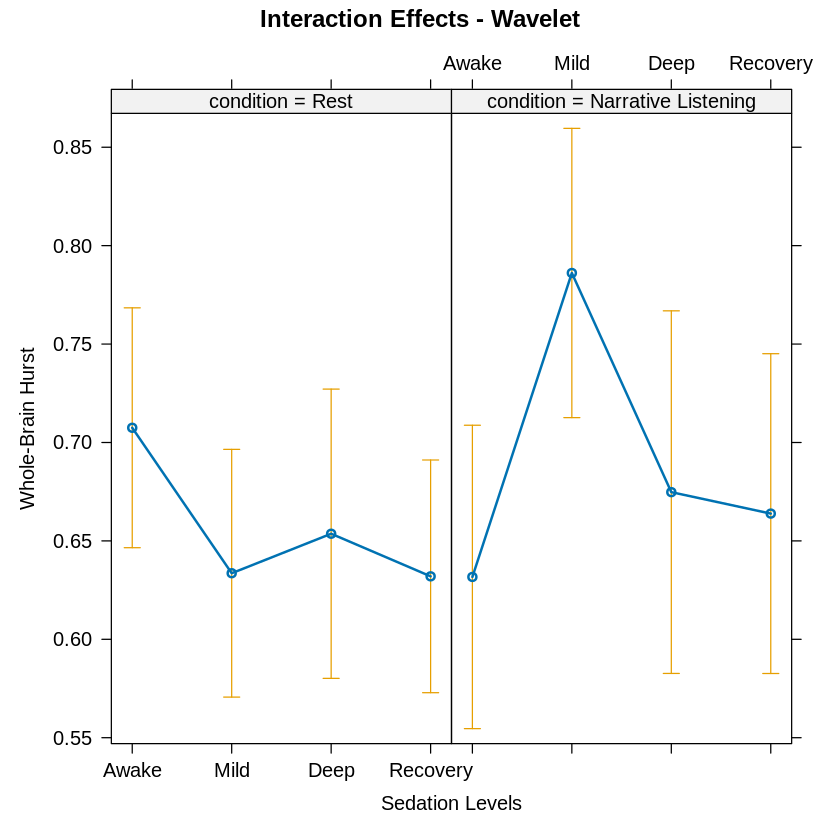

In [ ]:
# Interaction effects (Non-standardized)
mixed_effect_wavelet = lmer(hurst_average ~ sedation_level*condition + (1 | subject), data=wavelet)
summary(mixed_effect_wavelet)
anova(mixed_effect_wavelet)
plot(allEffects(mixed_effect_wavelet), main = "Interaction Effects - Wavelet", xlab = "Sedation Levels", ylab = "Whole-Brain Hurst")
emmeans(mixed_effect_wavelet, list(pairwise ~ sedation_level*condition), adjust = "tukey")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: hurst ~ sedation_level * condition + (1 | subject)
   Data: wavelet

REML criterion at convergence: 270.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.16027 -0.51071  0.04279  0.59173  2.56465 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.006879 0.08294 
 Residual             0.911001 0.95446 
Number of obs: 96, groups:  subject, 17

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)                  0.01376    0.10365 16.67100   0.133   0.8960  
sedation_level.L            -0.19315    0.19652 80.63312  -0.983   0.3286  
sedation_level.Q            -0.22084    0.20344 84.91851  -1.086   0.2808  
sedation_level.C             0.20138    0.20976 80.70893   0.960   0.3399  
condition1                  -0.12670    0.10163 80.92746  -1.247   0.2161  
sedation_level.L:condition1 -0.16732  

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
sedation_level,3.088863,1.029621,3,81.94549,1.130208,0.34177702
condition,1.415998,1.415998,1,80.92746,1.554333,0.21609340
sedation_level:condition,10.000089,3.333363,3,78.53337,3.659012,0.01589395


Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
“the predictor hurst is a one-column matrix that was converted to a vector”


$`emmeans of sedation_level, condition`
 sedation_level condition            emmean    SE df lower.CL upper.CL
 Awake          Rest                 0.2839 0.240 88   -0.193    0.760
 Mild           Rest                -0.2933 0.248 88   -0.786    0.199
 Deep           Rest                -0.1366 0.291 88   -0.715    0.442
 Recovery       Rest                -0.3057 0.232 88   -0.767    0.156
 Awake          Narrative Listening -0.3081 0.306 88   -0.916    0.299
 Mild           Narrative Listening  0.8982 0.291 88    0.320    1.477
 Deep           Narrative Listening  0.0284 0.367 88   -0.701    0.758
 Recovery       Narrative Listening -0.0567 0.323 88   -0.698    0.585

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of sedation_level, condition`
 1                                                        estimate    SE   df
 Awake Rest - Mild Rest                                    0.57722 0.344 75.2
 Awake Rest - Deep Rest                

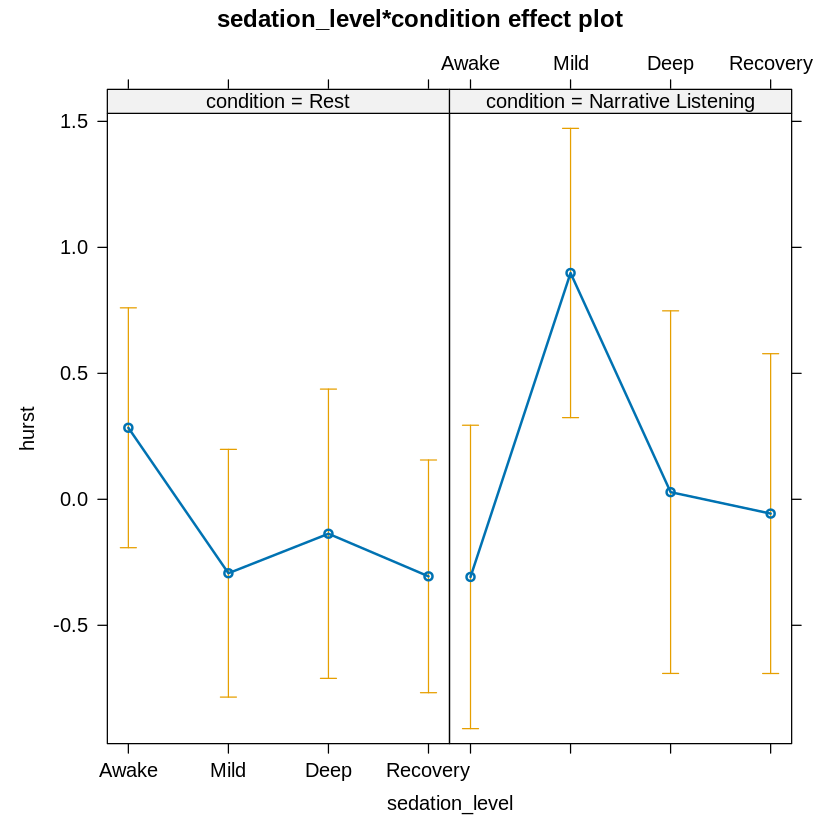

In [ ]:
# Interaction effects
mixed_effect_wavelet = lmer(hurst ~ sedation_level*condition + (1 | subject), data=wavelet)
summary(mixed_effect_wavelet)
anova(mixed_effect_wavelet)
plot(allEffects(mixed_effect_wavelet))
emmeans(mixed_effect_wavelet, list(pairwise ~ sedation_level*condition), adjust = "tukey")

In [ ]:
full <- x %>%
  full_join(wavelet, by = c("subject", "sedation_level", "condition")) %>%
  drop_na(hurst_average.x, hurst_average.y)

 full

 write.csv(full, "/content/full.csv")

subject,condition,sedation_level,hurst_average.x,r_squared,hurst.x,hurst_average.y,hurst.y
<fct>,<fct>,<fct>,<dbl>,<dbl>,"<dbl[,1]>",<dbl>,"<dbl[,1]>"
02CB,Narrative Listening,Awake,0.5676822,0.9341010,-0.37608605,0.5321307,-1.08580007
02CB,Narrative Listening,Mild,0.6238171,0.9484309,0.24871305,0.8700108,1.55367710
02CB,Narrative Listening,Deep,0.6850942,0.9497898,0.93074695,0.6198189,-0.40079029
02CB,Rest,Awake,0.7320398,0.9586631,1.45326619,0.7574029,0.67399847
02CB,Rest,Mild,0.6701008,0.9608697,0.76386614,0.7047818,0.26292917
02CB,Rest,Deep,0.6585643,0.9587932,0.63546097,0.6933563,0.17367457
02CB,Rest,Recovery,0.6103574,0.9602742,0.09890222,0.6021268,-0.53899877
04HD,Narrative Listening,Awake,0.5734274,0.9380520,-0.31213980,0.5916899,-0.62053033
04HD,Narrative Listening,Recovery,0.4670465,0.9402378,-1.49619330,0.4407185,-1.79990061



Call:
lm(formula = full$hurst_average.x ~ full$hurst_average.y)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.170007 -0.037932  0.003226  0.045976  0.099691 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.28865    0.03312   8.716 1.06e-13 ***
full$hurst_average.y  0.47878    0.04830   9.912 3.14e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05847 on 93 degrees of freedom
Multiple R-squared:  0.5137,	Adjusted R-squared:  0.5085 
F-statistic: 98.25 on 1 and 93 DF,  p-value: 3.141e-16


`geom_smooth()` using formula = 'y ~ x'


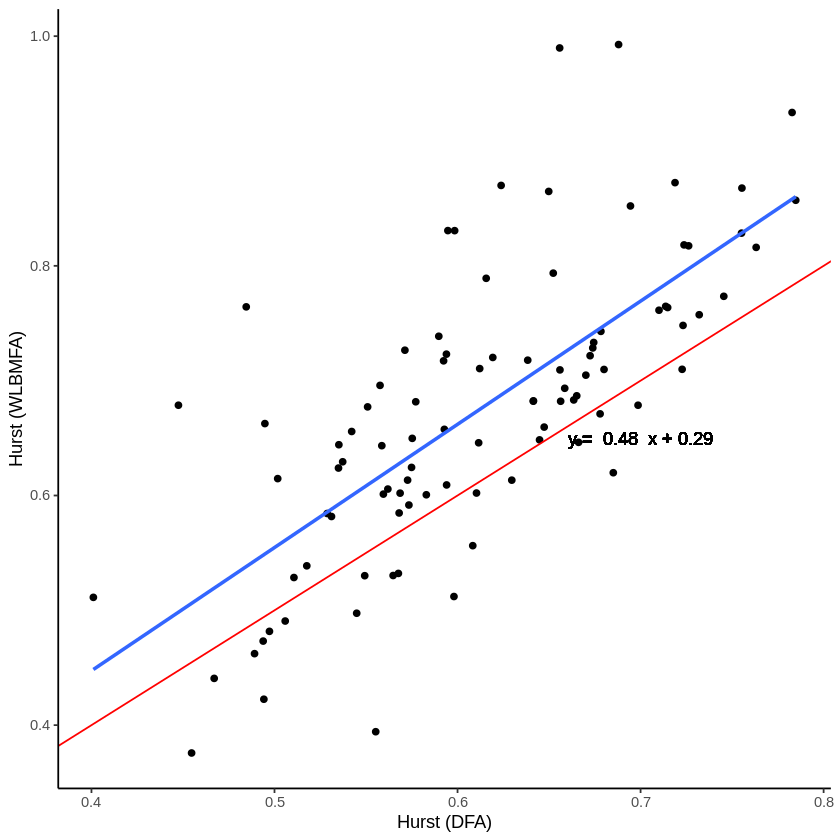

In [ ]:
# t.test(full$hurst_average.x, full$hurst_average.y, paired = TRUE)

model <- lm(full$hurst_average.x ~ full$hurst_average.y)
summary(model)

# cor <- cor.test(full$hurst_average.x, full$hurst_average.y, method = "pearson")
# print(cor)

ggplot(data = full, aes(x = hurst_average.x, y = hurst_average.y)) +
  geom_point() +
  theme_classic() +
  xlab("Hurst (DFA)") +
  ylab("Hurst (WLBMFA)") +
  geom_smooth(method = "lm", se = FALSE) +
  geom_abline(intercept = 0, slope = 1, color = "red" ) +
  geom_text(aes(x = 0.7, y = 0.65, label = paste("y = ", round(model$coefficients[2], 2), " x +", round(model$coefficients[1], 2))))

# plot(full$hurst_average.x, full$hurst_average.y)
# abline(lm(full$hurst_average.x ~ full$hurst_average.y))
# abline(a = 0, b = 1, col = "red")

In [ ]:
## The following code is to separate recovery early from recovery late (discarded)
# Separate recovery early from recovery late in the rest
rest_100 <- read.csv("/rest_100.csv") %>%
  separate(col = X, into = c("subject"), convert = TRUE, sep = "_") %>%
  mutate(recovery_early = rowMeans(across(X0:X9), na.rm = TRUE)) %>%
  mutate(recovery_late = rowMeans(across(X36:X45), na.rm = TRUE)) %>%
  mutate(condition = "rest") %>%
  select("subject", "recovery_early" ,"recovery_late", "condition") %>%
  pivot_longer(c("recovery_early", "recovery_late"), names_to = "sedation_level", values_to = "hurst_average") %>%
  mutate(hurst = scale(hurst_average)) %>%
  select("subject", "sedation_level", "hurst", "condition") %>%
  full_join(x, by = c("subject", "sedation_level", "hurst", "condition")) %>%
  filter(condition == "rest") %>%
  filter(sedation_level != "Recovery")

rest_100$subject <- factor(rest_100$subject)
rest_100$sedation_level <- factor(rest_100$sedation_level, levels=c("Awake","Mild", "Deep", "recovery_early", "recovery_late"))

contrasts(rest_100$sedation_level) = contr.poly(5)
options(contrasts=c("contr.sum","contr.poly"))

rest_100

Warning message in file(file, "rt"):
“cannot open file '/rest_100.csv': No such file or directory”


ERROR: ignored

In [ ]:
# Main effect of sedation level in the rest condition (recovery separated)
mixed_effect_rest_100 = lmer(hurst ~ sedation_level + (1 | subject), data=rest_100)
summary(mixed_effect_rest_100)
anova(mixed_effect_rest_100)
plot(allEffects(mixed_effect_rest_100))
emmeans(mixed_effect_rest_100, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Separate recovery early from recovery late in the movie condition
movie_100 <- read.csv("/movie_100.csv") %>%
  separate(col = X, into = c("subject"), convert = TRUE, sep = "_") %>%
  mutate(recovery_early = rowMeans(across(X0:X15), na.rm = TRUE)) %>%
  mutate(recovery_late = rowMeans(across(X49:X64), na.rm = TRUE)) %>%
  mutate(condition = "movie") %>%
  select("subject", "recovery_early" ,"recovery_late", "condition") %>%
  pivot_longer(c("recovery_early", "recovery_late"), names_to = "sedation_level", values_to = "hurst_average") %>%
  mutate(hurst = scale(hurst_average)) %>%
  select("subject", "sedation_level", "hurst", "condition") %>%
  full_join(x, by = c("subject", "sedation_level", "hurst", "condition")) %>%
  filter(condition == "movie") %>%
  filter(sedation_level != "Recovery")

movie_100$subject <- factor(movie_100$subject)
movie_100$sedation_level <- factor(movie_100$sedation_level, levels=c("Awake","Mild", "Deep", "recovery_early", "recovery_late"))

contrasts(movie_100$sedation_level) = contr.poly(5)
options(contrasts=c("contr.sum","contr.poly"))

movie_100

In [ ]:
# Main effect of sedation level in the movie condition (recovery separated)
mixed_effect_movie_100 = lmer(hurst ~ sedation_level + (1 | subject), data=movie_100)
summary(mixed_effect_movie_100)
anova(mixed_effect_movie_100)
plot(allEffects(mixed_effect_movie_100))
emmeans(mixed_effect_movie_100, list(pairwise ~ sedation_level), adjust = "tukey")

In [ ]:
# Separate recovery early from recovery late across movie/rest condition
total_100 <- rest_100 %>%
  full_join(movie_100)

total_100$subject <- factor(total_100$subject)
total_100$sedation_level <- factor(total_100$sedation_level, levels=c("Awake","Mild", "Deep", "recovery_early", "recovery_late"))

contrasts(total_100$sedation_level) = contr.poly(5)
options(contrasts=c("contr.sum","contr.poly"))

total_100

In [ ]:
# Interaction effects (recovery separated)
mixed_effect_total_100 = lmer(hurst ~ sedation_level*condition + (1 | subject), data=total_100)
summary(mixed_effect_total_100)
anova(mixed_effect_total_100)
plot(allEffects(mixed_effect_total_100))
emmeans(mixed_effect_total_100, list(pairwise ~ sedation_level*condition), adjust = "tukey")